In [17]:
import dill
dill.load_session('notebook_env.db')

#### Splitting dataset into train and test

In [11]:
from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Number transactions train dataset: ", len(X_train_undersample))
print("Number transactions test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample)+len(X_test_undersample))


Number transactions train dataset:  481
Number transactions test dataset:  207
Total number of transactions:  688

Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


#### Using K-fold cross validation on train set to hypertune c_parameter for logistic regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report

In [13]:

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
def printing_Kfold_scores(x,y):
    fold = KFold(n_splits=5,shuffle=False) 

    # Different C parameters
    c_param_range = [0.01,0.1,1,10,100]

    
    

    mean_scores=[]
    
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        
        for train_index, test_index in fold.split(x):
            X_train, X_test, y_train, y_test = x.iloc[train_index,1:], x.iloc[test_index,1:], y.iloc[train_index,1:], y.iloc[test_index,1:]
            #print(X_train)
#             X_train, X_test = x[train_index], x[test_index]
#             y_train, y_test = y[train_index], y[test_index]
            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C = c_param, penalty = 'l1')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(X_train,y_train)

            # Predict values using the test indices in the training data
            y_pred = lr.predict(X_test)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_test,y_pred)
            recall_accs.append(recall_acc)
            print('Recall score = ', recall_acc)

        # The mean value of those recall scores is the metric we want to save and get hold of.
        mean_scores.append(np.mean(recall_accs))
        
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')

    results_table=pd.DataFrame(c_param_range,mean_scores)
    results_table.columns=['k-fold recall']
   
    
    return results_table

In [14]:
X=X_train_undersample.reset_index()
y=y_train_undersample.reset_index()

# best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample)
results_df = printing_Kfold_scores(X,y)
print(results_df)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Recall score =  0.8082191780821918
Recall score =  0.821917808219178
Recall score =  0.8813559322033898
Recall score =  0.9054054054054054
Recall score =  0.8939393939393939

Mean recall score  0.8621675435699118

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Recall score =  0.8493150684931506
Recall score =  0.863013698630137
Recall score =  0.9661016949152542
Recall score =  0.9459459459459459
Recall score =  0.8939393939393939

Mean recall score  0.9036631603847762

-------------------------------------------
C parameter:  1
-------------------------------------------

Recall score =  0.863013698630137
Recall score =  0.8904109589041096
Recall score =  0.9830508474576272
Recall score =  0.9459459459459459
Recall score =  0.9090909090909091

Mean recall score  0.9183024720057457

--------------------------------------

Recall metric in the testing dataset:  0.9251700680272109


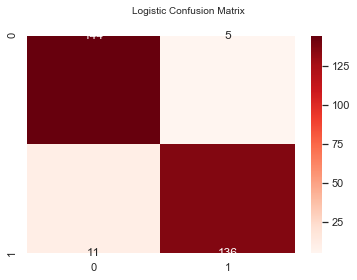

In [15]:
import seaborn as sns
lr = LogisticRegression(C = 100, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)



# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix


sns.set(font_scale=1)
plt.suptitle('Logistic Confusion Matrix', fontsize=10)
sns.heatmap(cnf_matrix,annot=True,cmap="Reds",fmt="d")
plt.show()

Recall metric in the testing dataset:  0.9455782312925171


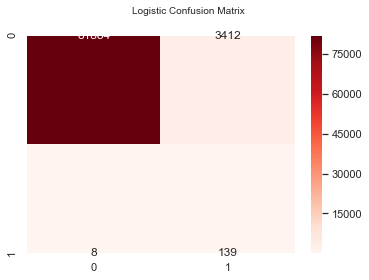

In [18]:
lr = LogisticRegression(C = 100, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

sns.set(font_scale=1)
plt.suptitle('Logistic Confusion Matrix', fontsize=10)
sns.heatmap(cnf_matrix,annot=True,cmap="Reds",fmt="d")
plt.show()

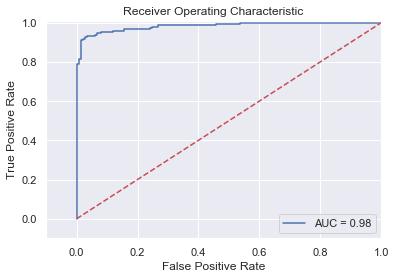

In [19]:
# ROC CURVE
lr = LogisticRegression(C = 100, penalty = 'l1')
y_pred_undersample_score = lr.fit(X_train_undersample,y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(),y_pred_undersample_score)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()